In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import math



class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        super(Bottle2neck, self).__init__()
        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        self.nums = scale - 1
        self.convs = nn.ModuleList([nn.Conv2d(width, width, kernel_size=3, stride=1, padding=1, bias=False) for _ in range(self.nums)])
        self.bns = nn.ModuleList([nn.BatchNorm2d(width) for _ in range(self.nums)])
        
        # 调整 conv3 和 bn3 层的参数
        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, stride=stride, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.width = width
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        
        
        
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            
            
            
            sp = self.convs[i](sp)
            sp = self.bns[i](sp)
            sp = self.relu(sp)
            
         
            
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
            
           
        out = torch.cat((out, spx[self.nums]), 1)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

       
        out += residual
        out = self.relu(out)

        return out




class Res2Net(nn.Module):
    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=100):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.baseWidth, self.scale))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [11]:
def train_and_evaluate(model, trainloader, testloader, num_epochs=10):


    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
        scheduler.step()
     # 绘制损失和准确度曲线
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # 绘制训练损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练和测试准确度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Training and Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/100], Loss: 5.8020, Train Accuracy: 1.40%, Test Accuracy: 2.45%
Epoch [2/100], Loss: 4.3109, Train Accuracy: 3.49%, Test Accuracy: 5.77%
Epoch [3/100], Loss: 4.0452, Train Accuracy: 6.66%, Test Accuracy: 7.63%
Epoch [4/100], Loss: 3.8807, Train Accuracy: 9.14%, Test Accuracy: 8.93%
Epoch [5/100], Loss: 3.6926, Train Accuracy: 12.17%, Test Accuracy: 13.65%
Epoch [6/100], Loss: 3.5241, Train Accuracy: 15.15%, Test Accuracy: 19.27%
Epoch [7/100], Loss: 3.3665, Train Accuracy: 18.10%, Test Accuracy: 21.16%
Epoch [8/100], Loss: 3.2505, Train Accuracy: 20.37%, Test Accuracy: 21.87%
Epoch [9/100], Loss: 3.1659, Train Accuracy: 21.71%, Test Accuracy: 23.27%
Epoch [10/100], Loss: 3.0530, Train Accuracy: 24.20%, Test Accuracy: 24.22%
Epoch [11/100], Loss: 2.9609, Train Accuracy: 25.86%, Test Accuracy: 28.17%
Epoch [12/100], Loss: 2.8895, Train Accuracy: 27.31%, Test Accuracy: 28.56%
Epoch [13/100], Loss: 2.7990,

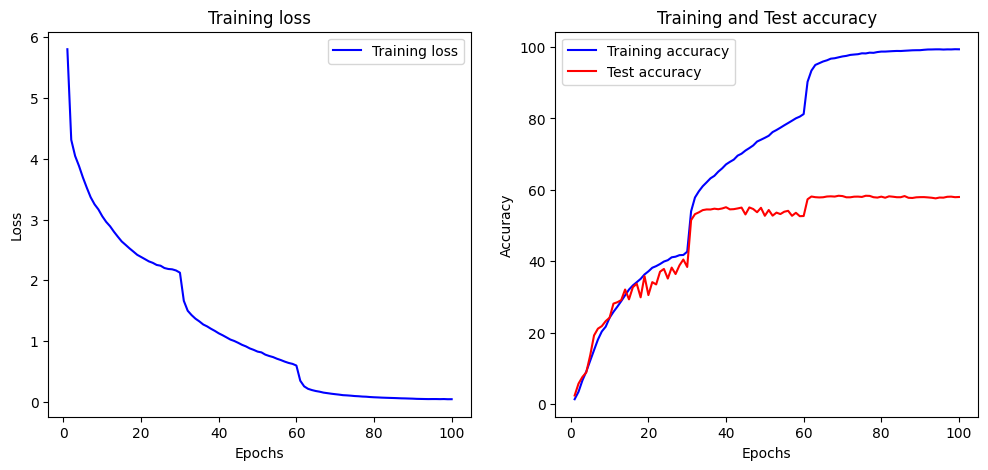

In [12]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Res2Net(Bottle2neck, [3, 4, 6, 3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_and_evaluate(model, trainloader, testloader, num_epochs=100)
